# Setup

set working directory to guitarist-net and add to path

In [1]:
%cd /content/drive/Othercomputers/My MacBook Pro/guitarist-net

/content/drive/Othercomputers/My MacBook Pro/guitarist-net


install requirements

In [2]:
!pip install -r requirements.txt &> /dev/null

imports

In [3]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import librosa
import librosa.display
from plot_listen.listen import play
from plot_listen.plot import plot, plot_single_string_item
from save_load import load_weights_from_file
from util import torch_to_numpy
from globals import *
from data.single_string_dataset import SingleStringDataset
from ddsp.ddsp_mono_synth import DDSPMonoSynth
from torch.utils.data import DataLoader

# Load Trained Model

create model

In [4]:
synth = DDSPMonoSynth()

using sweetcocoa trainable reverb.


load weights, move to GPU, set to eval mode

In [5]:
synth.load_state_dict(load_weights_from_file())
synth = synth.to(DEVICE)
synth.eval();

Type a number to select an option:
	0)	2022-07-08 08:08PM DDSP Mono Synth : training test
	1)	2022-07-09 01:40PM DDSP Mono Synth : load model and continue training
	2)	2022-07-09 11:45PM DDSP Mono Synth : resume training (third time)
	3)	2022-07-10 10:44AM DDSP Mono Synth : train (4th time)
	4)	2022-07-19 04:05PM DDSP Mono Synth Improved : synth_improvement
	5)	2022-07-19 06:56PM DDSP Mono Synth : train with loudness centered and 32 osc + 32 filter coeffs
	6)	2022-07-20 10:48AM DDSP Mono Synth : train low E
	7)	2022-07-20 12:24PM DDSP Mono Synth Improved : improve 32 param synth - e string
	8)	2022-07-20 07:03PM DDSP Mono Synth : train with lr scheduler
	9)	2022-07-22 11:34AM DDSP Mono Synth : train low E for a while
	10)	2022-07-25 06:42PM DDSP Mono Synth : train with Leaky ReLU
	11)	2022-07-26 04:41PM DDSP Mono Synth : try training with test dataset (one guitarist)
	12)	2022-07-27 06:09PM DDSP Mono Synth : folder deleting, harmonic + noise saving
	13)	2022-07-27 06:12PM DDSP Mono Syn

# Load Dataset

get datasets

In [6]:
train_dataset = SingleStringDataset()

Type a number to select an option:
	0)	test_player-00_e-string.npz
	1)	train_player-not00_e-string.npz
	2)	test_player-00_E-string.npz
	3)	train_player-not00_E-string.npz
	4)	test_player-00_solo_E-string.npz
	5)	train_player-not00_solo_E-string.npz
	6)	test_player-00_solo_e-string.npz
	7)	train_player-not00_solo_e-string.npz
	8)	test_player-00_solo_e-string_1.0s_crepe.npz
	9)	train_player-not00_solo_e-string_1.0s_crepe.npz
	10)	test_player-00_solo_B-string_1.0s_crepe.npz
	11)	train_player-not00_solo_B-string_1.0s_crepe.npz
	12)	test_player-00_solo_G-string_1.0s_crepe.npz
	13)	train_player-not00_solo_G-string_1.0s_crepe.npz
	14)	test_player-00_solo_D-string_1.0s_crepe.npz
	15)	train_player-not00_solo_D-string_1.0s_crepe.npz
	16)	test_player-00_solo_A-string_1.0s_crepe.npz
	17)	train_player-not00_solo_A-string_1.0s_crepe.npz
	18)	test_player-00_solo_E-string_1.0s_crepe.npz
	19)	train_player-not00_solo_E-string_1.0s_crepe.npz
Selection: 9
train_player-not00_solo_e-string_1.0s_crepe.npz


# Input Data

set index

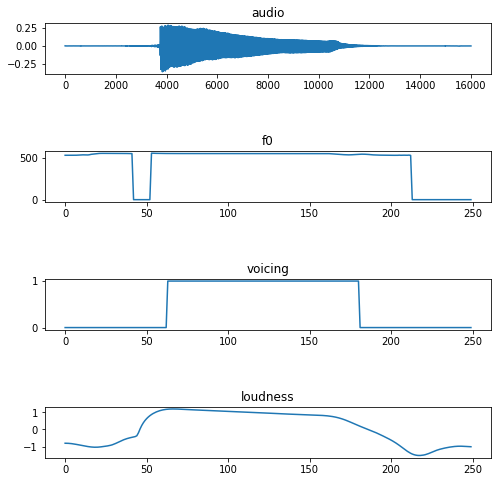

In [7]:
idx = 122
input_data = train_dataset[idx]
plot_single_string_item(input_data)

load f0 + loudness labels

optionally alter inputs

In [8]:
pitch_shift = 0
loudness_scale = 1

input_f0 = torch.tensor(input_data['f0']).unsqueeze(0).to(DEVICE) # cast as torch tensor, insert batch size of 1
input_loudness = torch.tensor(input_data['loudness']).unsqueeze(0).to(DEVICE) # cast as torch tensor, insert batch size of 1

input_f0 *= 2**(pitch_shift / 12)
input_loudness *= loudness_scale

feed into model


In [9]:
output = synth(input_f0, input_loudness)

# Examine output

In [10]:
play(output['reverb_audio'][0])

### compare original + resynthesized spectrograms

show spectrograms

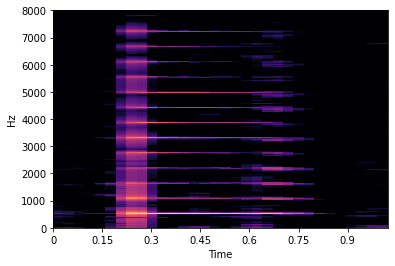

In [11]:
og_audio = input_data['audio']
og_spec = librosa.amplitude_to_db(np.abs(librosa.stft(og_audio)))
og_img = librosa.display.specshow(og_spec, y_axis='linear', x_axis='time', sr=SR)

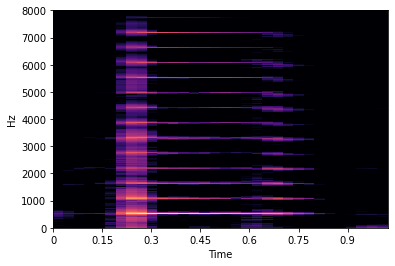

In [12]:
resynth_audio = torch_to_numpy(output['reverb_audio'][0])
resynth_spec = librosa.amplitude_to_db(np.abs(librosa.stft(resynth_audio)))
resynth_img = librosa.display.specshow(resynth_spec, y_axis='linear', x_axis='time', sr=SR)

### harmonic part

predicted overall amplitude (harmonic part)

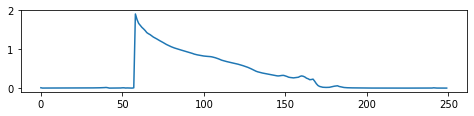

In [13]:
plt.figure(figsize = (8,1.5))
plot(output['overall_amplitude'][0])

predicted harmonic distribution

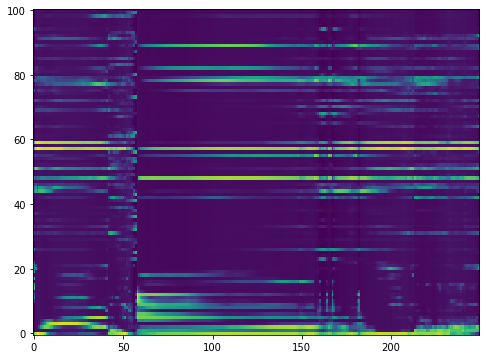

In [14]:
plt.figure(figsize = (8,6))
harm_distr = output['harm_distr'][0]
plt.imshow(torch_to_numpy(harm_distr), aspect='auto', interpolation='none', origin='lower')

predicted harmonic audio

In [15]:
play(output['harmonic'][0])

### noise part

predicted filter coefficients

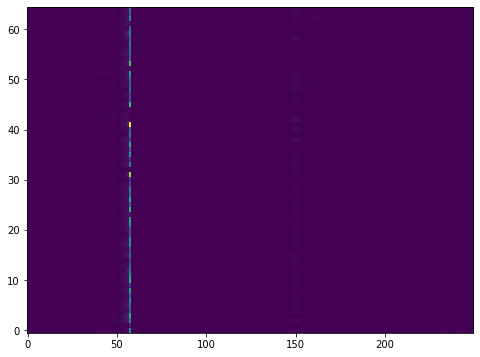

In [16]:
plt.figure(figsize = (8,6))
filter_coeff = output['H'][0].T
plt.imshow(torch_to_numpy(filter_coeff), aspect='auto', interpolation='none', origin='lower');

In [17]:
play(output['noise'][0])

### "reverb"

before reverb

In [18]:
play(output["audio"])

after reverb

In [19]:
play(output["reverb_audio"])

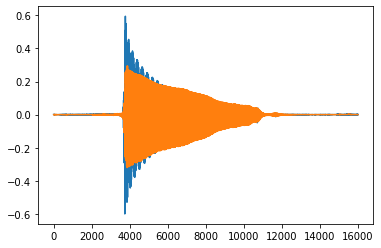

In [20]:
plot(output["audio"][0]) # blue
plot(output["reverb_audio"][0]) # orange

extract learned reverb params

In [21]:
reverb_module = synth.trainable_reverb
reverb_fir = reverb_module.fir
reverb_drywet = reverb_module.drywet
reverb_decay = reverb_module.decay
reverb_length = reverb_module.reverb_length

construct reverb IR

In [22]:
decay_envelope = torch.exp(
    -(torch.exp(reverb_decay) + 2)
    * torch.linspace(0, 1, reverb_length, dtype=torch.float32).to(DEVICE)
)
decay_fir = reverb_fir * decay_envelope

ir_identity = torch.zeros(1, reverb_fir.shape[-1]).to(DEVICE)
ir_identity[:, 0] = 1

final_fir = (
    torch.sigmoid(reverb_drywet) * decay_fir + (1 - torch.sigmoid(reverb_drywet)) * ir_identity
)

barely any "reverb"

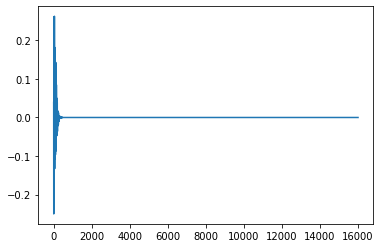

In [23]:
plot(final_fir[0])

zoom in on the beginning

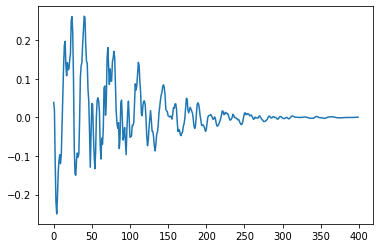

In [24]:
plot(final_fir[0,:400])

decays to 0 by ~250 samples

at SR of 16k, 250 samples = 15.625 ms

### plot freqz of learned filter

In [25]:
import torch.fft

In [26]:
fft_of_reverb_ir = torch.fft.fft(final_fir[0])

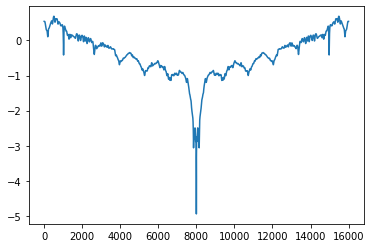

In [27]:
plot(torch.log10(abs(fft_of_reverb_ir)))

# Inspect Inharmonicity

learned inharmonicity parameter

In [28]:
inharm_beta = synth.harmonic_oscillator.inharm_beta

In [29]:
print(inharm_beta)

Parameter containing:
tensor([-14.9907], device='cuda:0', requires_grad=True)


In [30]:
print(torch.sigmoid(inharm_beta))

tensor([3.0875e-07], device='cuda:0', grad_fn=<SigmoidBackward0>)


starting value

In [31]:
print(torch.sigmoid(torch.tensor([-20])))

tensor([2.0612e-09])
